# Spatial Differential Expression

This notebook will cover an example of the spatial differential expression step of the BayesTME pipeline, using our melanoma dataset as an example.

First download the dataset form https://www.dropbox.com/s/aha4mcdrq12myfi/ST_mel1_rep2_counts.tsv?dl=0 and save it in your current working directory.

We will also use the result of the deconvolution step, produced in the previous notebook.

We will first load these into our data models:


In [4]:
from bayestme import data

deconvolution_result = data.DeconvolutionResult.read_h5('./bayestme_melanoma_deconvolution_result.h5ad')
stdata = data.SpatialExpressionDataset.read_h5('./bayestme_melanoma_stdata.h5ad')

Next we will sample from the spatial differential expression posterior distribution.

We will only run for a limited number of samples for the sake of computational brevity. Normally we would use a much higher number of samples.

We will use the lambda smoothing parameter learned from k-fold cross-validation.

The `n_spatial_patterns` parameter 

In [12]:
from bayestme import spatial_expression
import numpy as np

np.random.seed(0)
results = spatial_expression.run_spatial_expression(
    dataset=stdata,
    deconvolve_results=deconvolution_result,
    n_spatial_patterns=10,
    n_samples=50,
    n_burn=20,
    n_thin=1,
    n_cell_min=5,
    alpha0=10,
    prior_var=100.0,
    lam2=1000,
    simple=True)

Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Step 30
Step 31
Step 32
Step 33
Step 34
Step 35
Step 36
Step 37
Step 38
Step 39
Step 40
Step 41
Step 42
Step 43
Step 44
Step 45
Step 46
Step 47
Step 48
Step 49
Step 50
Step 51
Step 52
Step 53
Step 54
Step 55
Step 56
Step 57
Step 58
Step 59
Step 60
Step 61
Step 62
Step 63
Step 64
Step 65
Step 66
Step 67
Step 68
Step 69


As a result of sampling the spatial differential expression posterior, we have learned 10 spatial differential expresison patterns for each of our 4 cell types.

Many of these spatial programs we have learned will just be capturing technical noise and overdispersion rather than meaningful spatial signal.

As a result we have derived a method for filtering out these spatial programs and selecting ones that are more likely to represent meaningful signal.

In this example, because we are using so few samples, we have relaxed these criteria below just for demonstration purposes.

In [37]:
import logging
spatial_expression.logger.setLevel(logging.DEBUG)

significant_programs = [_ for _ in spatial_expression.select_significant_spatial_programs(
        stdata=stdata,
        decon_result=deconvolution_result,
        sde_result=results,
        tissue_threshold=0,
    gene_spatial_pattern_proportion_threshold=0.6,
    cell_correlation_threshold=0.7,
    moran_i_score_threshold=0.7
)]

'{} significant programs found'.format(len(significant_programs))

DEBUG:bayestme.spatial_expression:No genes have proportion > gene_spatial_pattern_proportion_threshold 0.6 for cell type 0 pattern 1, dropping.
DEBUG:bayestme.spatial_expression:No genes have proportion > gene_spatial_pattern_proportion_threshold 0.6 for cell type 0 pattern 2, dropping.
DEBUG:bayestme.spatial_expression:No genes have proportion > gene_spatial_pattern_proportion_threshold 0.6 for cell type 0 pattern 3, dropping.
DEBUG:bayestme.spatial_expression:n_cell_correlation >= cell_correlation_threshold 0.7 for cell type 0 pattern 4, dropping.
DEBUG:bayestme.spatial_expression:No genes have proportion > gene_spatial_pattern_proportion_threshold 0.6 for cell type 0 pattern 5, dropping.
DEBUG:bayestme.spatial_expression:No genes have proportion > gene_spatial_pattern_proportion_threshold 0.6 for cell type 0 pattern 6, dropping.
DEBUG:bayestme.spatial_expression:No genes have proportion > gene_spatial_pattern_proportion_threshold 0.6 for cell type 0 pattern 7, dropping.
DEBUG:bayest

'1 significant programs found'

BayesTME includes plotting code, we call `plot_spatial_pattern_with_legend` to show this differential expression pattern and the genes involved in it:

In [60]:
import bayestme
from bayestme.spatial_expression import *

def plot_spatial_pattern_legend(
        fig: matplotlib.figure.Figure,
        ax: matplotlib.axes.Axes,
        stdata: data.SpatialExpressionDataset,
        sde_result: data.SpatialDifferentialExpressionResult,
        gene_ids: np.array,
        k: int,
        colormap):
    loadings = sde_result.v_samples[:, gene_ids, k].mean(axis=0).flatten()
    loadings /= np.max(np.abs(loadings)) * np.sign(loadings[np.argmax(np.abs(loadings))])
    genes_selected = gene_ids[abs(loadings) > 0.1]
    loadings = loadings[abs(loadings) > 0.1]
    plot_order = np.argsort(loadings)
    loading_plot = loadings[plot_order]
    genes_selected_in_plot_order = genes_selected[plot_order]
    vmin = min(-1e-4, loading_plot.min())
    vmax = max(1e-4, loading_plot.max())
    norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    legend_elements = []
    for i, g in enumerate(genes_selected_in_plot_order):
        legend_elements.append(
            Line2D([0], [0], marker='o',
                   color=colormap(norm(loading_plot[i])),
                   label=stdata.gene_names[genes_selected_in_plot_order[i]],
                   markerfacecolor=colormap(norm(loading_plot[i])),
                   markersize=abs(loading_plot[i]) * 20,
                   linestyle='none')
        )
    legend_elements.reverse()

    ax.legend(handles=legend_elements, loc='center', fontsize=10, labelspacing=2, frameon=False)
    ax.set_axis_off()
    
bayestme.spatial_expression.plot_spatial_pattern_legend = plot_spatial_pattern_legend

[[ 18]
 [ 21]
 [ 40]
 [173]
 [361]
 [714]
 [819]]


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 7

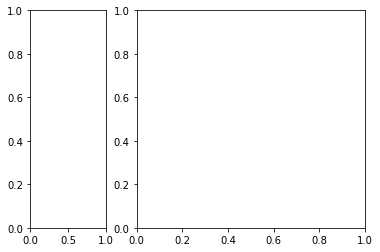

In [63]:
k, h, gene_ids = significant_programs[0]

print(gene_ids)

spatial_expression.plot_spatial_pattern_with_legend(
    stdata=stdata,
    decon_result=deconvolution_result,
    sde_result=results,
    gene_ids=gene_ids.T,
    k=k,
    h=h,
    output_file='./significant_sde_pattern.jpg'
)

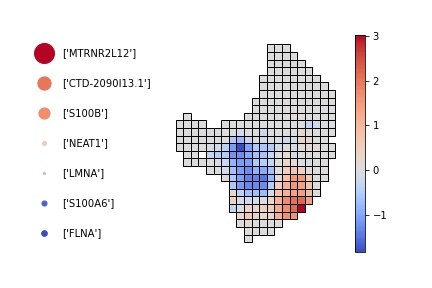

In [64]:
from IPython.display import Image

Image('./significant_sde_pattern.jpg')